## Importing Modules Needed

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

We set our image to be 224 x 224 in RGB color (3)

In [2]:
image_size = (224, 224)

We have decided to use Transfer Learning tehcnique and choose MobileNetV3 Small as our base model

In [3]:
base_model = tf.keras.applications.MobileNetV2(
    include_top=False, 
    weights='imagenet', 
    input_shape=(image_size[0], image_size[1], 3),
)

## Prepare The Data

This cell is used to define the data augmentation, we only applied the augmentation in training data

In [4]:
# Preprocess the input images and apply augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

Our dataset is inside "data" folder, which already split into train and valid sub folders

In [5]:
base_path = "data/Plant Disease/Plants Disease Dataset Subset" #Local Notebook
source_path = os.path.join(base_path, "Tomato")
train_path = os.path.join(source_path, "train")
valid_path = os.path.join(source_path, "valid")

Arrange the dataset by creating train and validation data generators. We also specify tha batch size and target image size here

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    shuffle = True
)

validation_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=image_size,
    batch_size=10,
    class_mode='categorical',
    shuffle = False
)

Found 712 images belonging to 10 classes.
Found 200 images belonging to 10 classes.


## Defining the model
Inside our model we use MobileNetV3 Small combine them with more layer to increase the accuracy. We also specify the last/output layer with 10 Neuron since we have 10 classes in total

In [43]:
# from tensorflow.keras import regularizers

for layer in base_model.layers[:-2]:
    layer.trainable = False

with tf.device("GPU"):
    model = Sequential()
    model.add(base_model)
    model.add(Dropout(0.3))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))

# Compile the model
learning_rate = 0.01
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 dropout_14 (Dropout)        (None, 7, 7, 1280)        0         
                                                                 
 global_average_pooling2d_12  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_37 (Dense)            (None, 256)               327936    
                                                                 
 dense_38 (Dense)            (None, 128)               32896     
                                                                 
 dense_39 (Dense)            (None, 10)              

We train our model with some callbacks to save the checkpoints and run on 30 epoch with monitoring on validation accuracy

In [44]:
checkpoint_callback = ModelCheckpoint('./saved_model/tomato_mw_v2.h5', save_best_only=True, save_weights_only=True)
early_stopping_callback = EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)
reduce_lr_callback = ReduceLROnPlateau(factor=0.1, patience=3, monitor='val_accuracy')

epoch = 20
with tf.device('GPU'):
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epoch,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=[
            # checkpoint_callback, 
            # early_stopping_callback, 
            reduce_lr_callback
            ]
    )

Epoch 1/20
23/23 [==============================] - 25s 938ms/step - loss: 4.5074 - accuracy: 0.1952 - val_loss: 1.9899 - val_accuracy: 0.2850 - lr: 0.0100
Epoch 2/20
23/23 [==============================] - 19s 841ms/step - loss: 1.4191 - accuracy: 0.5154 - val_loss: 1.3799 - val_accuracy: 0.4950 - lr: 0.0100
Epoch 3/20
23/23 [==============================] - 19s 827ms/step - loss: 1.0131 - accuracy: 0.6390 - val_loss: 1.2163 - val_accuracy: 0.5800 - lr: 0.0100
Epoch 4/20
23/23 [==============================] - 19s 828ms/step - loss: 0.8144 - accuracy: 0.7317 - val_loss: 0.9564 - val_accuracy: 0.6350 - lr: 0.0100
Epoch 5/20
23/23 [==============================] - 19s 820ms/step - loss: 0.6739 - accuracy: 0.7669 - val_loss: 0.9240 - val_accuracy: 0.6850 - lr: 0.0100
Epoch 6/20
23/23 [==============================] - 19s 816ms/step - loss: 0.6166 - accuracy: 0.7753 - val_loss: 0.8246 - val_accuracy: 0.7250 - lr: 0.0100
Epoch 7/20
23/23 [==============================] - 19s 823ms/st

## Plotting the result

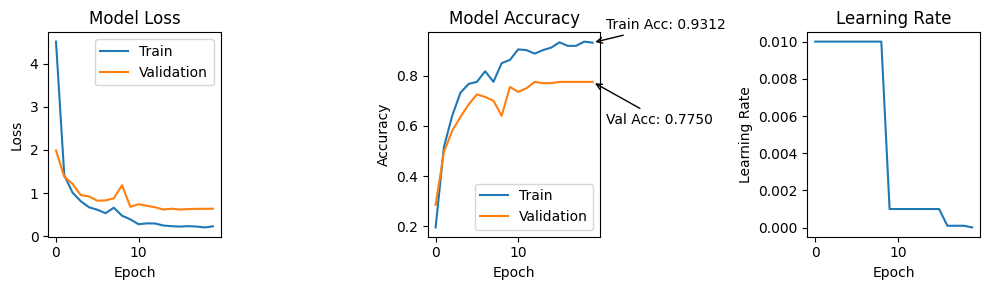

In [45]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[0].set_title('Model Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend(['Train', 'Validation'], loc='upper right')

axes[1].plot(history.history['accuracy'])
axes[1].plot(history.history['val_accuracy'])
axes[1].set_title('Model Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend(['Train', 'Validation'], loc='lower right')

axes[2].plot(history.history['lr'])
axes[2].set_title('Learning Rate')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Learning Rate')

# Print the final training and validation accuracy
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
axes[1].annotate(f'Train Acc: {final_train_accuracy:.4f}', xy=(len(history.history['accuracy']) - 1, final_train_accuracy), xytext=(10, 10),
                 textcoords='offset points', arrowprops=dict(arrowstyle='->', color='black'))
axes[1].annotate(f'Val Acc: {final_val_accuracy:.4f}', xy=(len(history.history['val_accuracy']) - 1, final_val_accuracy), xytext=(10, -30),
                 textcoords='offset points', arrowprops=dict(arrowstyle='->', color='black'))

plt.tight_layout()
plt.show()

# Save the model and convert to .tflite

In [46]:
export_dir = './saved_model/tomato/3'
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: ./saved_model/tomato/3\assets


INFO:tensorflow:Assets written to: ./saved_model/tomato/3\assets


In [47]:
# mode = "Speed" 

# if mode == 'Storage':
#     optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
# elif mode == 'Speed':
#     optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
# else:
#     optimization = tf.lite.Optimize.DEFAULT

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [48]:
import pathlib
tflite_model_file = pathlib.Path('./assets/tomato_disease9377.tflite')
tflite_model_file.write_bytes(tflite_model)

2873680